In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss, auc, roc_curve
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import scipy.sparse as sp
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from nltk.tokenize import WordPunctTokenizer
import spacy
import scipy.sparse as sp
import shap

- Импортируем все файлы
- Убираем название аниме
- Энкодим таргет
- Убираем дупликаты
- Убираем пропуски

In [ ]:
part_1 = pd.read_excel('dataset1.xlsx')
part_2 = pd.read_excel('dataset2.xlsx')
part_3 = pd.read_excel('dataset3.xlsx')
part_4 = pd.read_excel('dataset4.xlsx')
df = pd.concat([part_1, part_2, part_3, part_4]).copy()

In [ ]:
df.drop(columns='Anime', axis=1, inplace=True)
label_encoder = LabelEncoder()
norm_labels = label_encoder.fit_transform(df['Rate'].to_list())
df['class'] = norm_labels
df.drop(columns='Rate', axis=1, inplace=True)
df = df.reset_index().drop(columns='index')
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

0 - нейтральный, 1 - негативный, 2 - положительный

Проверим на дисбаланс классов

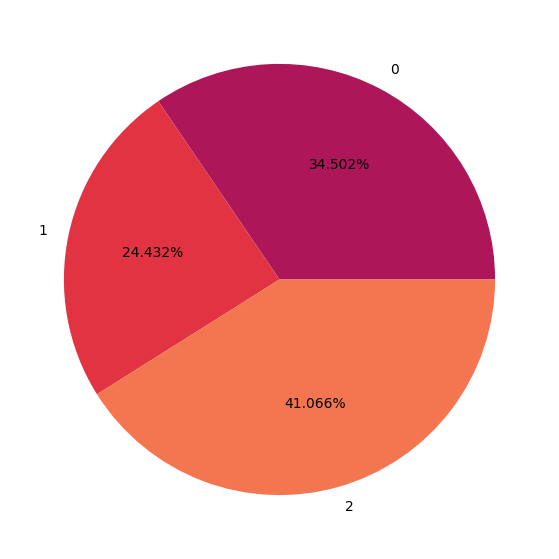

In [ ]:
plot_disbalance = pd.DataFrame(df['class'].value_counts(normalize=True).mul(100).sort_index())
fig = plt.figure(figsize=(10, 7))
colors = sns.color_palette('rocket')[2:5]
plt.pie(plot_disbalance['proportion'], labels=plot_disbalance.index, colors=colors, autopct='%.3f%%')
plt.show()

Хочу найти все варицации xd, привести их к одному формату и добавить кол-во xd как фичу

In [ ]:
def normalize_xd(text):
    pattern = re.compile(r'[xX]+[dD]+')
    return pattern.sub('xd', text)

df['Text'] = df['Text'].apply(normalize_xd)
df['xd'] = df['Text'].apply(lambda x: x.count('xd'))

Убираем ссылки

In [ ]:
def remove_links(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+|example\.\S+|vk\.\S+')
    return url_pattern.sub('', text)
df['Text'] = df['Text'].apply(remove_links)

Первая очевидная фича - длина отзыва

In [ ]:
df['text_length'] = df['Text'].apply(lambda x: len(x))

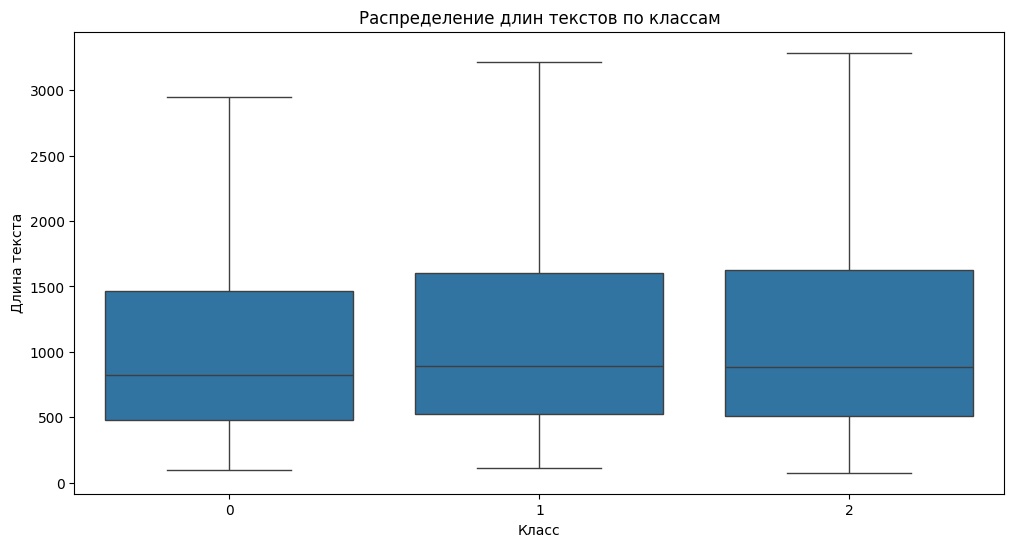

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='text_length', data=df, showfliers=False)
plt.title('Распределение длин текстов по классам')
plt.xlabel('Класс')
plt.ylabel('Длина текста')
plt.show()

In [ ]:
pd.concat([df[df['class'] == 0]['text_length'].describe(), df[df['class'] == 1]['text_length'].describe(), df[df['class'] == 2]['text_length'].describe()], axis=1)

,text_length,text_length,text_length
count,25247.000000,17878.000000,30050.000000
mean,1218.100329,1337.362736,1349.927354
std,1283.703081,1444.873502,1461.121441
min,99.000000,109.000000,75.000000
25%,477.000000,523.000000,512.000000
50%,825.000000,890.000000,882.000000
75%,1465.000000,1600.000000,1622.000000
max,32767.000000,32767.000000,32767.000000


In [ ]:
fliers = {0: df[df['class'] == 0]['text_length'].quantile(0.75), 1: df[df['class'] == 1]['text_length'].quantile(0.75), 2: df[df['class'] == 2]['text_length'].quantile(0.75)}
out_fliers = {0: df[(df['class'] == 0) & (df['text_length'] > fliers[0])].shape[0], 1: df[(df['class'] == 1) & (df['text_length'] > fliers[1])].shape[0] , 2: df[(df['class'] == 2) & (df['text_length'] > fliers[2])].shape[0]}
print('Кол-во выбросов для класса 0: ', out_fliers[0])
print('Кол-во выбросов для класса 1: ', out_fliers[1])
print('Кол-во выбросов для класса 2: ', out_fliers[2])

df['quant075'] = df['class'].apply(lambda x: fliers[x])
df['outlier'] = (df['text_length'] > df['quant075']).astype(str)
df.drop(columns='quant075', axis=1, inplace=True)
df.drop(columns='outlier', axis=1, inplace=True)

Кол-во выбросов для класса 0:  6310
Кол-во выбросов для класса 1:  4466
Кол-во выбросов для класса 2:  7512


In [ ]:
df['num_exclam'] = df['Text'].apply(lambda x: x.count('!'))
excl = {0: df[(df['class'] == 0) & (df['num_exclam'] > 0)].shape[0], 1: df[(df['class'] == 1) & (df['num_exclam'] > 0)].shape[0], 2: df[(df['class'] == 2) & (df['num_exclam'] > 0)].shape[0]}
print('Кол-во отзывов с воскл знаками класса 0: ', excl[0])
print('Кол-во отзывов с воскл знаками класса 1: ', excl[1])
print('Кол-во отзывов с воскл знаками класса 2: ', excl[2])

Кол-во отзывов с воскл знаками класса 0:  6576
Кол-во отзывов с воскл знаками класса 1:  4796
Кол-во отзывов с воскл знаками класса 2:  9442


Убираем даты, очень большие числа + обрабатываем случай, когда пользователь говорит о книгах и упоминаем страниц 88-101 и тп

In [ ]:
def remove_dates_and_large_numbers(text):
    pattern = re.compile(r'\b\d{4,}\b')
    text = pattern.sub('', text)
    pattern = re.compile(r'\b\d{2,}-\d{3,}\b')
    return pattern.sub('', text)

df['Text'] = df['Text'].apply(remove_dates_and_large_numbers)

Нужно извлечь рейтинг, который ставят любители аниме в своих отзывах. Так как они могу указать рейтинг разными способами: 9/10; 9 из 10;  9.5/10;  8.5-9.0/10 и тд, то пришлось повозиться

In [ ]:
def extract_rating(text):
    pattern = re.compile(r'\b(\d{1,2}(?:[.,]\d{1,2})?)\b(?:[-/]?\d*(?:[.,]?\d+)?\/?10| из 10)')
    match = pattern.search(text)
    if match:

        if float(match.group(1).replace(',', '.')) > 100:
            return 100
        else:
            return float(match.group(1).replace(',', '.'))
    return -1
df['rating'] = df['Text'].apply(extract_rating)

In [ ]:
pd.concat([df[(df['class'] == 0) & (df['rating'] >= 0)]['rating'].describe(), df[(df['class'] == 1) & (df['rating'] >= 0)]['rating'].describe(), df[(df['class'] == 2) & (df['rating'] >= 0)]['rating'].describe()], axis=1)

,rating,rating,rating
count,9596.000000,6952.000000,11532.000000
mean,7.660354,5.212476,8.926575
std,2.518212,2.509907,2.515396
min,0.000000,0.000000,0.000000
25%,7.000000,4.000000,8.000000
50%,8.000000,5.000000,9.000000
75%,8.500000,6.000000,10.000000
max,90.000000,70.000000,99.900000


In [ ]:
def idk_rating(x):
    if x == -1: return 'no_inf'
    elif x <= 6.25: return 'bad'
    elif x <= 8.25: return 'neutral'
    else: return 'good'

df['rating'] = df['rating'].apply(idk_rating)

In [ ]:
df

,Text,class,text_length,num_exclam,xd,rating
0,"после первой арки несколько разочаровался, ожи...",0,185,0,0,no_inf
1,"Концовка какая-то мутная, ничего не понял. Над...",2,148,0,0,no_inf
2,"Что тут сказать? Никакого сравнени я с Seed, х...",2,897,1,0,bad
3,Только что досмотрел и меня переполняют эмоции...,2,560,0,0,no_inf
4,"И правда не оторваться. Но, по-моему, то, что ...",2,311,1,0,no_inf
...,...,...,...,...,...,...
73211,Я просмотрел 82 серии Пожирателя звёзд (Swallo...,2,858,0,0,no_inf
73212,Я был сильно заинтригован аниме Поглощающая Зв...,2,931,0,0,no_inf
73213,докатились. после просмотра этого чуда я добав...,0,794,0,0,no_inf
73214,Вокруг этого произведения собралось достаточно...,2,2262,0,0,neutral


In [ ]:
from nltk.tokenize import WordPunctTokenizer
import spacy

nlp = spacy.load("ru_core_news_lg")
tokenizer = WordPunctTokenizer()

In [ ]:
def smart_cleaning(text):
    tokens = tokenizer.tokenize(text)
    we = ' '.join([i for i in tokens if i.isalpha()])
    doc = nlp(we)
    lemmas = ' '.join([token.lemma_ for token in doc])
    return lemmas

In [ ]:
df['cleaned_text'] = df['Text'].apply(smart_cleaning)

Идея: скорее всего именно прилагательные будут давать эмоциональный окрас. Давайте найдем все прилагательные и дадим им скор из модельки для сентимент анализа. Затем, если в отзыве есть прилагательные - то найдем сумму их скоров, если прилагательных нет - то дадим 0

In [ ]:
model_sent = pipeline("sentiment-analysis", "blanchefort/rubert-base-cased-sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Пройдемся по всем словам, которые встречались хотя бы 5 раз и найдем все прилагательные

In [ ]:
token_counter = Counter()
for one_string in df['cleaned_text'].values:
    for token in one_string.split():
        token_counter[token] += 1

norm_words = [i for i,v in token_counter.items() if v > 4]

adjectives = {}
for i in tqdm(norm_words):
    if nlp(i)[0].pos_ == 'ADJ':
        adjectives[i] = token_counter[i]
adjectives = {k: v for k, v in sorted(adjectives.items(), key=lambda item: item[1], reverse=True)}

Тут получаю словарик {прилагательное1: скор1;  прилагательное2: скор2, ...}

In [ ]:
new_adj = {}
for i,v in tqdm(adjectives.items()):
    lab = model_sent(i)[0]['label']
    score = model_sent(i)[0]['score']
    if lab == 'NEGATIVE':
        new_adj[i] = -score
    elif lab == 'POSITIVE':
        new_adj[i] = score
    elif lab == 'NEUTRAL':
        new_adj[i] = 0

100%|██████████| 7290/7290 [20:57<00:00,  5.80it/s]


In [ ]:
def count_score(text):
    score = 0
    for i in text.split():
        if i in set_adjectives:
            score += new_adj[i]
    return score

set_adjectives = set(new_adj.keys())
df['score'] = df['cleaned_text'].apply(count_score)

Имеем такие файлики:
<br> - cleaned.csv - отчищенный текст
<br> - score.csv - наш подсчитанный скор
<br> - data1-4.csv - все остальные фичи

In [ ]:
df.iloc[:18000].to_csv('data1.csv')
df.iloc[18000:36000].to_csv('data2.csv')
df.iloc[36000:54000].to_csv('data3.csv')
df.iloc[54000:].to_csv('data4.csv')

df[['cleaned_text']].to_csv('cleaned.csv', index=False)

df[['score']].to_csv('score.csv')